## Part 1:

Gather the dataset of hubNashville requests from https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh. For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". Explore this dataset, looking at when and where these violations occurred.



In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [3]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [4]:
#subsetting for case_requests and case_subrequest

hubNashville = hubNashville[hubNashville['case_subrequest'] == 'COVID-19 Violations']

In [5]:
#assigning unnecessary columns
cols = ['case_request', 'case_subrequest', 'additional_subrequest', 'state_issue', 'closed_when_created', 'contact_type','parent_case', 'status', 'date_time_closed', 'case_origin', 'incident_council_district', 'mapped_location']

#dropping unnecessary columns
hubNashville = hubNashville.drop(columns=cols, axis=1)

In [6]:
#converting open to datetime

hubNashville['date_time_opened'] = [pd.to_datetime(d) for d in hubNashville['date_time_opened']]

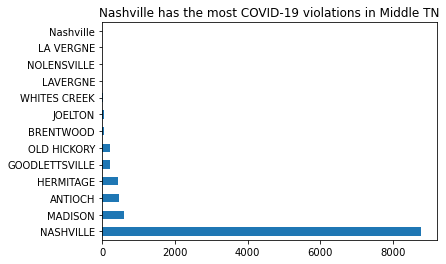

In [7]:
hubNashville['incident_city'].value_counts().plot(kind='barh', 
                                                  title='Nashville has the most COVID-19 violations in Middle TN');

Nashville leads the number of violations with ____

/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


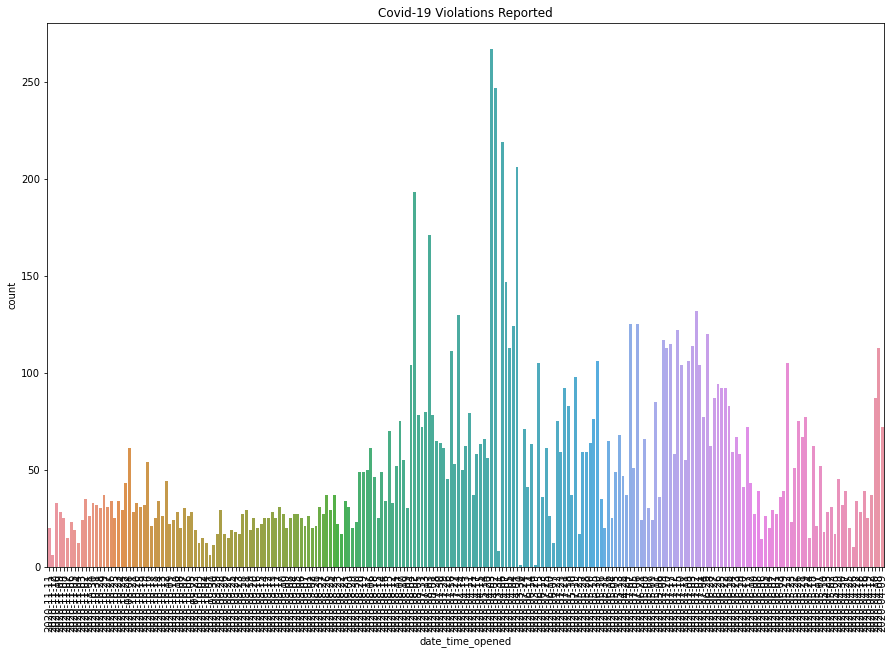

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
data = hubNashville['date_time_opened'].dt.strftime('%Y-%m-%d')
sns.countplot(data)
plt.xticks(rotation='vertical')
plt.title('Covid-19 Violations Reported');

In [9]:
#creating new column with value_counts
hubNashville['opened_year_month_date'] = hubNashville['date_time_opened'].dt.strftime('%Y-%m-%d')

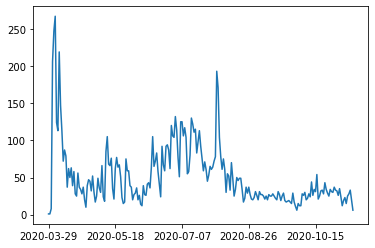

In [10]:
hubNashville['opened_year_month_date'].value_counts().sort_index().plot();

In [11]:
#reading zipcode data
zipcodes = gpd.read_file('../data/nashzipcodes.geojson')
print(zipcodes.crs)
zipcodes.head()

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [12]:
#creating geometry column for plotting with geopandas
hubNashville['geometry'] = hubNashville.apply(lambda x: Point((float(x.longitude),
                                                               float(x.latitude))),
                                              axis=1)

In [13]:
# create geodataframe of hubNashville
hubNashville_geo = gpd.GeoDataFrame(hubNashville, 
                           crs = zipcodes.crs, 
                           geometry = hubNashville['geometry'])

In [14]:
#dropping duplicates so plotting will work
hubNashville_geo = hubNashville_geo.dropna()

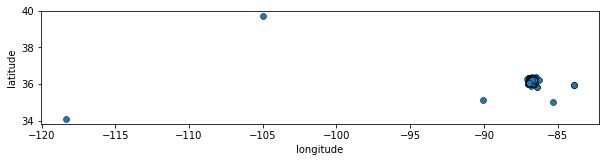

In [15]:
ax = zipcodes.plot(figsize = (10, 10), color = 'white', edgecolor = 'lightgrey')

sns.scatterplot(data=hubNashville_geo, x='longitude', y='latitude', 
                palette='mako_r', sizes=(10, 20), edgecolor = 'black');

## Part 2:
The file davidson_cases.csv contains the number of COVID cases in Davidson county per day from March 8 through October 29. Use this dataset to compare the trend for the number of cases over time to the number of reported violations. Feel free to add any additional data that you think might be useful.

In [16]:
davidsonco_cases = pd.read_csv('../data/davidson_cases.csv')
davidsonco_cases.head()

,date,county,state,fips,cases,deaths
0,2020-03-08,Davidson,Tennessee,47037,1,0
1,2020-03-09,Davidson,Tennessee,47037,1,0
2,2020-03-10,Davidson,Tennessee,47037,1,0
3,2020-03-11,Davidson,Tennessee,47037,2,0
4,2020-03-12,Davidson,Tennessee,47037,6,0


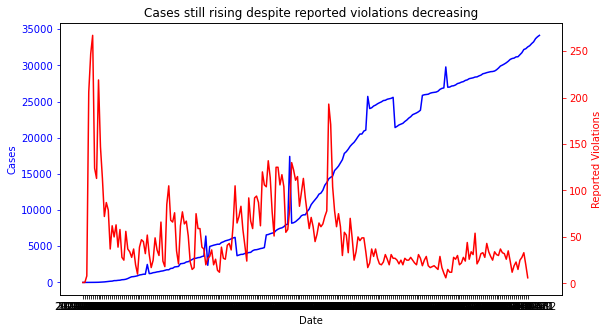

In [17]:
#data
violations_by_day = hubNashville.groupby('opened_year_month_date').size().to_frame('count')

#plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(davidsonco_cases['date'], davidsonco_cases['cases'], 
           color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Cases', color='blue')
ax.tick_params('y', colors='blue')
ax2 = ax.twinx()
ax2.plot(violations_by_day.index, violations_by_day['count'],          
         color='red')
ax2.set_ylabel('Reported Violations', color='red')
ax2.tick_params('y', colors='red')
plt.title('Cases still rising despite reported violations decreasing');

## Part 3:
The Metro Public Health Department tracks COVID-19 clusters. The files clusters.csv and clusters_by_type.csv contain the tables of clusters as reported by WSMV along with the coordinates of the clusters. Can you find any connection between the reported COVID violations and subsequent COVID clusters?

In [18]:
clusters = pd.read_csv('../data/clusters_revised.csv')

In [19]:
#creating geometry column
clusters['geometry'] = clusters.apply(lambda x: Point((float(x.Longitude), 
                                                         float(x.Latitude))), 
                                        axis=1)
clusters.head()

,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude,geometry
0,Vanderbilt Parties,Social Gathering,3/11/2020,49,36.144703,-86.802655,POINT (-86.8026551 36.1447034)
1,Event at Clementine Hall,Social Gathering,3/14/2020,23,36.152444,-86.844583,POINT (-86.84458290000001 36.15244420000001)
2,Religious Retreat,Social Gathering,3/25/2020,18,NaN,NaN,POINT (nan nan)
3,The Health Center at Richland Place,LTCF,4/3/2020,47,36.128750,-86.817345,POINT (-86.8173446 36.12874979999999)
4,Trevecca Center for Rehab and Healing,LTCF,4/4/2020,102,36.144562,-86.754560,POINT (-86.7545598 36.1445623)


In [20]:
clusters = clusters.dropna()

In [21]:
#geodataframe for clusters data
clusters_geo = gpd.GeoDataFrame(clusters, 
                           crs = zipcodes.crs, 
                           geometry = clusters['geometry'])

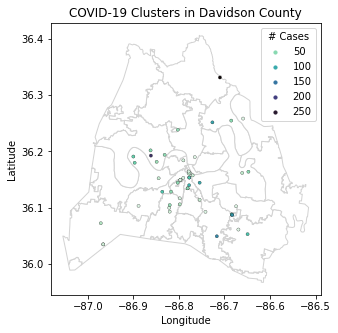

In [22]:
ax = zipcodes.plot(figsize = (5, 5), color = 'white', edgecolor = 'lightgray')

sns.scatterplot(data=clusters, x="Longitude", y="Latitude", hue="# Cases", palette="mako_r", size="# Cases", sizes=(10, 10), edgecolor = 'black')
plt.title('COVID-19 Clusters in Davidson County');

In [23]:
#merging violations and clusters on lat/long to get business names
violations_clusters = pd.merge(hubNashville, clusters, left_on=['latitude', 'longitude'],
                              right_on=['Latitude', 'Longitude'])

In [24]:
violations_clusters.head()

,case_number,date_time_opened,incident_address,incident_city,incident_zip_code,latitude,longitude,opened_year_month_date,geometry_x,Cluster Name,Facility Type,Cluster Start Date,# Cases,Latitude,Longitude,geometry_y
0,498041,2020-11-09 04:44:05,207 Printers Alley,NASHVILLE,37201.0,36.164369,-86.778515,2020-11-09,POINT (-86.77851 36.16437),Miss Kelli's,Bar,10/1/2020,14,36.164369,-86.778515,POINT (-86.77851 36.16437)
1,487902,2020-10-25 04:22:34,207 Printers Alley,NASHVILLE,37201.0,36.164369,-86.778515,2020-10-25,POINT (-86.77851 36.16437),Miss Kelli's,Bar,10/1/2020,14,36.164369,-86.778515,POINT (-86.77851 36.16437)
2,482950,2020-10-18 04:24:54,207 Printers Alley,NASHVILLE,37201.0,36.164369,-86.778515,2020-10-18,POINT (-86.77851 36.16437),Miss Kelli's,Bar,10/1/2020,14,36.164369,-86.778515,POINT (-86.77851 36.16437)
3,471299,2020-09-26 18:30:59,207 Printers Alley,NASHVILLE,37201.0,36.164369,-86.778515,2020-09-26,POINT (-86.77851 36.16437),Miss Kelli's,Bar,10/1/2020,14,36.164369,-86.778515,POINT (-86.77851 36.16437)
4,391515,2020-06-13 04:43:17,207 Printers Alley,NASHVILLE,37201.0,36.164369,-86.778515,2020-06-13,POINT (-86.77851 36.16437),Miss Kelli's,Bar,10/1/2020,14,36.164369,-86.778515,POINT (-86.77851 36.16437)


In [25]:
#assigning unnecessary columns
cols = ['Latitude', 'Longitude', 'geometry_y']

#dropping unnecessary columns
violations_clusters = violations_clusters.drop(columns=cols, axis=1)

## Part 4:
The dataset from data.nashville.gov includes geospatial information, which allows you to see where violations occurred geographically, but it does not provide information in regard to the specific businesses that were reported. In this part, you should explore the businesses and types of businesses that have been reported. To attempt to answer this, you have been provided data from the Google Places API.

In [26]:
import glob
from pandas.io.json import json_normalize

In [27]:
google_results = pd.DataFrame() #create empty dataframe
for filename in glob.glob('../data/google_places_results/*.json'): # loop through .json files
    with open(filename) as f:
        google_files = json.load(f) # open the json file
        google_jsons = pd.json_normalize(google_files, sep='_', #normalize the json file for nested results
                            record_path='results')
        google_results = google_results.append(google_jsons) #append each json file results to dataframe

In [28]:
google_results.columns

Index(['business_status', 'icon', 'name', 'photos', 'place_id', 'price_level',
       'rating', 'reference', 'scope', 'types', 'user_ratings_total',
       'vicinity', 'geometry_location_lat', 'geometry_location_lng',
       'geometry_viewport_northeast_lat', 'geometry_viewport_northeast_lng',
       'geometry_viewport_southwest_lat', 'geometry_viewport_southwest_lng',
       'opening_hours_open_now', 'plus_code_compound_code',
       'plus_code_global_code', 'permanently_closed'],
      dtype='object')

In [29]:
#selecting only the columns we want
google_results = google_results[['name', 'types', 'vicinity', 'geometry_location_lat', 'geometry_location_lng']].reset_index(drop=True)

In [30]:
#renaming columns in preparation for merge
google_results = google_results.rename(columns={'vicinity': 'google_address', 
                               'geometry_location_lat': 'latitude',
                               'geometry_location_lng': 'longitude'})

In [31]:
#merging hubNashville with google_results
violations_google_results = hubNashville.merge(google_results, on=['latitude', 'longitude'])

In [32]:
#removing duplicates that have the same date_time_opened, latitude, and long
violations_google_results = violations_google_results.drop_duplicates(subset=['date_time_opened','latitude', 'longitude']).reset_index(drop=True)

In [33]:
violations_google_results

,case_number,date_time_opened,incident_address,incident_city,incident_zip_code,latitude,longitude,opened_year_month_date,geometry,name,types,google_address
0,500414,2020-11-11 22:34:37,174 3rd Ave N,NASHVILLE,37201.0,36.163657,-86.777299,2020-11-11,POINT (-86.77730 36.16366),Bowie’s Nashville,"[restaurant, bar, food, point_of_interest, est...","174 3rd Avenue North, Nashville"
1,340801,2020-04-06 21:40:53,174 3rd Ave N,NASHVILLE,37201.0,36.163657,-86.777299,2020-04-06,POINT (-86.77730 36.16366),Bowie’s Nashville,"[restaurant, bar, food, point_of_interest, est...","174 3rd Avenue North, Nashville"
2,500409,2020-11-11 22:24:35,410 39th Ave N,NASHVILLE,37209.0,36.153211,-86.832682,2020-11-11,POINT (-86.83268 36.15321),Bold Patriot Brewing Company,"[food, point_of_interest, establishment]","410 39th Avenue North, Nashville"
3,423359,2020-07-22 18:55:02,410 39th Ave N,NASHVILLE,37209.0,36.153211,-86.832682,2020-07-22,POINT (-86.83268 36.15321),Bold Patriot Brewing Company,"[food, point_of_interest, establishment]","410 39th Avenue North, Nashville"
4,420098,2020-07-18 16:30:30,410 39th Ave N,NASHVILLE,37209.0,36.153211,-86.832682,2020-07-18,POINT (-86.83268 36.15321),Bold Patriot Brewing Company,"[food, point_of_interest, establishment]","410 39th Avenue North, Nashville"
...,...,...,...,...,...,...,...,...,...,...,...,...
2398,338816,2020-04-03 18:00:58,1321 Murfreesboro Pike,NASHVILLE,37217.0,36.114624,-86.695669,2020-04-03,POINT (-86.69567 36.11462),HawkEye Personal Protection - Executive Protec...,"[point_of_interest, establishment]","1321 Murfreesboro Pike STE 500, Nashville"
2399,338957,2020-04-03 19:35:04,200 Duke Dr,NaN,NaN,36.127146,-86.406556,2020-04-03,POINT (-86.40656 36.12715),O'Reilly Auto Parts,"[electronics_store, car_repair, point_of_inter...","200 Duke Drive Ste 200, Lebanon"
2400,338774,2020-04-03 17:30:15,100 Belle Valley Dr,NASHVILLE,37209.0,36.104146,-86.925634,2020-04-03,POINT (-86.92563 36.10415),Landmark at Lyncrest Reserve Apartment Homes,"[real_estate_agency, point_of_interest, establ...","100 Belle Valley Drive, Nashville"
2401,339141,2020-04-03 21:26:01,4066 Nolensville Pike,NASHVILLE,37211.0,36.080297,-86.724948,2020-04-03,POINT (-86.72495 36.08030),Regions Mortgage,"[finance, point_of_interest, establishment]","4066 Nolensville Pike, Nashville"


In [62]:
violations_google_results['name'].value_counts().head(15)

Nashville Ultimate Party Bus, LLC                        43
MoneyGram                                                42
Western Union                                            42
Davidson 4th Circuit Court Judge                         29
Kroger                                                   28
Professional photographers of nashville and middle TN    25
Sonic Drive-In                                           24
Kid Rock's Big Ass Honky Tonk Rock N' Roll Steakhouse    20
Scoreboard Bar & Grill                                   18
FedEx OnSite                                             17
adidas Outlet                                            15
FedEx Drop Box                                           14
MAPCO Mart                                               14
Clementine                                               13
Vibes Bar & Lounge                                       13
Name: name, dtype: int64

In [61]:
violations_google_results['name'].value_counts().describe()

count    1115.000000
mean        2.155157
std         3.280725
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        43.000000
Name: name, dtype: float64